In [2]:
#hidden cell to be executed BEFORE the presentation
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import dftpy
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.time_data import TimeData
from dftpy.optimization import Optimization
from dftpy.mpi import sprint
from IPython.lib.display import YouTubeVideo
from IPython.display import IFrame, HTML
#display(HTML("<style>.container { height:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 32em; }</style>"))

#display(IFrame("<style>.container { width:100% !important; }</style>"))

from ase.visualize import view
PP_list = {'Al': 'Al_lda.oe01.recpot'}

<center>
    <h1>Making and Breaking Electronic Structures</h1>
    <h2>Lessons from embedding and machine learning</h2>
<center>
<br>
    <br>
<table>
  <tr>
      <td><p><h1>Michele Pavanello</h1></p><p style="color:blue">@MikPavanello</p><p><h2>Rutgers University-Newark</h2></p><p style="color:blue"> http://prg.rutgers.edu</p></td>
      <td><img src="./figures/logos/run.png" width=400 /></td>
      <td><img src="./figures/random/qrcode_sns_24.png" width=350 /></td>
  </tr>
</table>
<br>
<br>
<br>

<h4><center>SNS, Pisa &centerdot; April 4, 2024</center></h4>

# Acknowledgements

In [5]:
display(IFrame('http://prg.rutgers.edu', width=2000, height=1600))

#### Funding: NSF, DOE, ACS-PRF, Rutgers
#### Collaborators: Oliviero Andreussi (Boise State), Mark Tuckerman (NYU), Francesco Paesani (UC San Diego)

# We aim to model `The Real World`
<table>
    <tr>
      <td><h3>Photocatalyst</h3></td>
        <td><h3>Catalytic nanoparticles</h3></td>
  </tr>
  <tr>
      <td><img src="figures/science/photocatalyst.png" height=500 /></td>
      <td><img src="figures/science/catalyst.png" height=500 /></td>
  </tr>
    <tr>
        <td>Chem. Comm., 43, 6551 (2009)</td>
        <td>PCCP, 21, 15080 (2019)</td>
    </tr>
</table>   

# Glancing at history: 1970s

<center>
    <img src="figures/random/g70.jpeg" width=800 />
</center>

# Today: available methods, pros and cons
<br>
<center>
    <img src="figures/science/electronic_structure3.png" width=1300 />
</center>

# The usual paradigm
<br>
<center>
    <img src="figures/science/electronic_structure4.png" width=400 />
</center>

<br>
<br>
<div class="alert alert-block alert-success"><center>Extremely useful. Has been so for 30 years.</center></div>

<div class="alert alert-block alert-danger"><center>Not suitable for mesoscale systems.</center></div>

# A better setup for the modern world
<br>
<center>
    <img src="figures/science/electronic_structure5.png" width=1000 />
</center>

One way to make this happen:
$$E=\sum_I E_I + E^{nad}$$

<center>$E^{nad}$ becomes the "effective interaction". It needs to be <b>fast</b> and <b>accurate</b>.</center>

# Can orbital-free DFT (OF-DFT) work as "effective interaction"?

<b>OF-DFT</b> is like DFT but <b>with only one orbital</b>

The variational function is the electron density <u>only</u>
$$n(\mathbf{r})=N |\phi(\mathbf{r})|^2$$

The energy functional is a pure functional of $n(\mathbf{r})$
$$E[n]=T_s[n]+ E_H[n]+E_{xc}[n]+\int n(\mathbf{r}) v_{ext}(\mathbf{r}) d \mathbf{r} $$

Ground state is found by direct minimization
$$n_0(\mathbf{r})=\text{argmin}_n\left[\mathcal{L}[n] = E[n]-\mu \left(\int n(\mathbf{r})d\mathbf{r}-N\right)\right]$$

<div class="alert alert-block alert-success"><center><b>Opportunities:</b> (1) No need to diagonalize any matrix! (2) Complexity $\mathcal{O}[N\ln N]$</center></div>
<div class="alert alert-block alert-danger"><center><b>Problem:</b> $T_s[n]$ exists, but it is not known...</center></div>

### OF-DFT's $T_s[n]$: (semi)local and nonlocal functionals
<br>
    <center>
    <img src="figures/science/local_nonlocal.png" width=1600 />
<p>W. Mi, MP JCP (2018) $\bullet$ W. Mi, MP PRB (2019)  $\bullet$ W. Mi, MP JPCL (2020)  $\bullet$ X. Shao, W. Mi, MP PRB (2021) $\bullet$ X. Shao, W. Mi, MP JPCL (2021)  $\bullet$ X. Shao, W. Mi, MP JCTC (2021) $\bullet$ W. Mi, K. Luo, S.B. Trickey, MP Chem Rev 123, 12039 (2023)</p>
    </center>

<center><div class="alert alert-block alert-danger">
    Ok... but is it really much faster than KS-DFT?
</div> 
    </center>

# OF-DFT in practice
### How hard is it to run an OF-DFT simulation?
1. Generate a model system
2. Set up an OF-DFT simulation engine
3. Pick a $T_s[n]$, <b>noninteracting kinetic energy density functional</b> (KEDF)
4. Define "total energy" and <b>minimize</b> $E[n]$ $\to n(\mathbf{r})$!!

## You can do it too! http://tinyurl.com/2am5948r
<center>
    <img src="figures/random/qrcode_DFTpy_colab.png" width=500 />
</center>


1. Generate a model system: bulk Al (cubic cell) with ASE

In [4]:
from ase.build import bulk
atoms = bulk('Al', 'fcc', a=4.05, cubic=True)
ions = Ions.from_ase(atoms)
view(ions, viewer='ngl')

2. Set up an OF-DFT simulation with `DFTpy`

In [4]:
IFrame('http://dftpy.rutgers.edu', width=1400, height=400)

In [5]:
grid = DirectGrid(lattice=ions.cell, nr=[24,24,24])
PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list)
rho_ini = DirectField(grid=grid)
rho_ini[:] = ions.get_ncharges()/ions.cell.volume
HARTREE = Functional(type='HARTREE')
XC = Functional(type='XC',name='LDA')

setting key: Al -> Al_lda.oe01.recpot


3. Pick a noninteracting kinetic energy density functional (KEDF), $T_s[n]$. Such as:
 
<br>

 - TF+vW: 
 $$T_{TFW}[n] = \int C_{TF} ~n^{5/3}(\mathbf{r})~ d\mathbf{r} + \int \frac{\nabla n^{1/2}(\mathbf{r})\cdot \nabla n^{1/2}(\mathbf{r})}{2} ~d\mathbf{r}$$

<br>

- Wang-Teter: 
$$T_{WT}[n] =\int n^{5/6}(\mathbf{r}) \omega_{WT}(|\mathbf{r}-\mathbf{r'}|) n^{5/6}(\mathbf{r'})d\mathbf{r}d\mathbf{r}' $$

In [6]:
#KE = Functional(type='KEDF',name='x_TF_y_vW')
KE = Functional(type='KEDF',name='WT')

4. Define "total energy" and minimize $E[n]$

In [7]:
%%time 
evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
opt = Optimization(EnergyEvaluator=evaluator, optimization_options = {'econv' : 1e-6}, optimization_method = 'TN')
rho = opt.optimize_rho(guess_rho=rho_ini)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -8.090977702543E+00     -8.090978E+00   7.877607E-01    1       1       2.726603E-02    
1       -8.338045517302E+00     -2.470678E-01   7.253145E-02    8       1       9.477496E-02    
2       -8.342969829854E+00     -4.924313E-03   4.169836E-03    8       1       1.566379E-01    
3       -8.343659761292E+00     -6.899314E-04   3.633766E-04    11      1       2.359030E-01    
4       -8.343676971350E+00     -1.721006E-05   2.863760E-05    6       1       2.830558E-01    
5       -8.343678842041E+00     -1.870691E-06   2.163162E-06    8       1       3.401191E-01    
6       -8.343679111573E+00     -2.695316E-07   2.069486E-07    11      1       4.198229E-01    
7       -8.343679128916E+00     -1.734353E-08   1.962083E-08    9       1       4.812198E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.29273560191851705
Chemical potential (eV)  : 7.9657407068

# How does OF-DFT compare with KS-DFT?

<h4 style="text-align: center;">Let's run a Quantum ESPRESSO calculation of the <b>same system</b> using <i>QEpy</i></h4>

In [8]:
IFrame('http://qepy.rutgers.edu', width=1400, height=400)

In [9]:
from qepy.driver import Driver

In [10]:
driver=Driver('qe_in.in', comm=None, iterative=True, logfile='qepy.out')
print("Number of K points: ", driver.get_number_of_k_points())
print("Energy Cutoff: ", driver.get_ecutrho(), "Ry")
print("# of grid points: ", driver.get_number_of_grid_points())

Number of K points:  666
Energy Cutoff:  80.0 Ry
# of grid points:  [24 24 24]


#### First diagonalize

In [11]:
%%time
driver.diagonalize()

CPU times: user 54.4 s, sys: 2.66 s, total: 57 s
Wall time: 53.4 s


#### Then mix and check for convergence

In [12]:
%%time
driver.mix()
print("SCF Error: ",driver.get_scf_error())

SCF Error:  0.029763162204627526
CPU times: user 1 ms, sys: 580 µs, total: 1.58 ms
Wall time: 1.28 ms


<center><div class="alert alert-block alert-danger">
    KS-DFT is two$+$ order of magnitude slower than nonlocal OF-DFT!
</div></center>

### Let's look at the quality of the density

In [13]:
rhoks=driver.data2field(driver.get_density())
drho=rhoks-rho
drho.write('drho.cube',ions=ions)
print("Density % error: ",np.abs(drho).integral()/2/rho.integral()*100)

Density % error:  1.2163460580686671


# OF-DFT can approach semiconductor surfaces

<center>
    <p style="font-size:100%; text-align:center;">Shao, Mi & Pavanello, Phys. Rev. B <b>104</b>, 045118 (2021)</p>
    <br>
    <img src="figures/science/ofdft_surfaces.png" width=1800 />
    <div class="alert alert-block alert-success">Correct trends. Semiquantitative results.</div>
</center>

# Mesoscale is at reach
<br>
<center>
    <p style="font-size:100%; text-align:center;"> J. Phys. Chem. Lett. <b>12</b>, 4134 (2021) &#x25C6; WIREs: Comp. Mol. Sci. <b>11</b>, e1482 (2021)</p>
    <br>
    <img src="figures/science/ofdft_showoff.png" width=1600 />
</center>

# OF-DFT <u>should</u> work as the "effective interaction"

 - For systems at equilibrium and out of equilibrium
 - For methods including DFT, WFT, and (working on it!) also for MM

<h1>OF-DFT: interactions between <u>several</u> KS-DFT subsystems</h1>
<h3> Density embedding or Subsystem DFT (sDFT)</h3>
<br>
<center><img src="figures/science/electronic_structure6.png" width=330 align="center" /></center>

$$E[n]\equiv E[\{n_I\}]=\underbrace{\sum_I E[n_I]}_{KS} + \underbrace{E^{nadd}[\{n_I\}]}_{OF}$$

$$E^{nadd}[\{n_I\}] = E[n] - \sum_IE[n_I] \to \tilde T_s^{nadd}[\{n_I\}]+E_{Hxc}^{nadd}[\{n_I\}]+ \text{Coulomb between subsystems}$$

<div class="alert alert-block alert-success"><center>A few 10s of subsystems: Doable on your laptop! </center></div>
<div class="alert alert-block alert-success"><center>A few 100s of subsystems: Doable on your HPC cluster!</center></div>

# Subsystem DFT (sDFT):
 - Implemented in ADF, Q-Chem, Serenity, Turbomole, CP2K, ... as well as Quantum ESPRESSO

In [14]:
IFrame('http://eqe.rutgers.edu', width=1200, height=300)

In [15]:
IFrame('http://edftpy.rutgers.edu', width=1200, height=350)

# Subsystem DFT (sDFT) - Timings
<br>
<center>
<img src="figures/science/sdft_timings.png" width=1300 />
</center>
<ul>
    <li> Comp. Phys. Comm. <b>269</b>, 108122 (2021)</li>
    <li> Int. J. Quantum Chem. <b>117</b> e25401 (2017)</li>
    <li> J. Phys. Chem. Lett. <b>10</b> 7554 (2019)</li>
</ul>
<div class="alert alert-block alert-success">
    <b>Good News: eQE and eDFTpy sDFT timings are exactly right!</b>
</div>

# sDFT for weakly interacting subsystems
<br>

<p style="font-size:100%; text-align:center;">Deviation against CCSD(T)/CBS for the S66 test set</p>

<table>
    <tr>
        <td>
            <center>
                <img src="figures/science/sdft_s66.png" width=700 />
            </center>
        </td>
        <td>&nbsp;&nbsp;&nbsp;&nbsp;</td>
        <td>
            <center>
                <img src="figures/science/S66_comparisons.png" width=700 />
            </center>
        </td>
    </tr>
    <tr>
        <td>
            <ul>
                <li> Comp. Phys. Comm. <b>269</b>, 108122 (2021)</li>
                <li> J. Chem. Theory Comput. <b>17</b> 3455 (2021)</li>
                <li> J. Phys. Chem. Lett. <b>11</b> 272 (2020)</li>
            </ul>
        </td>
        <td>
        </td>
        <td>
            <ul>
                <li> J. Chem. Theory Comput. <b>7</b> 2427 (2011)</li>
            </ul>
        </td>
    </tr>
    </tr>
</table>
<div class="alert alert-block alert-success">
    <b>sDFT approaches weakly interacting subsystems accurately</b>
</div>

# Liquids: water and CO$_2$

<center>
   <img src="figures/science/liquids.png" width=1100 />
</center>

<center>Mi, Ramos, Pavanello, J. Phys. Chem. Lett. (2019) $\bullet$ Genova, Ceresoli, Pavanello, J. Chem. Phys. (2016)</center>

# sDFT seems to be accurate and predictive.  
## There are several open problems.

1) metallic subsystems are too expensive

2) large number of subsystems requires exascale

3) we'd like to use sDFT for those systems where KS-DFT is inadequate
 

## Choose your own adventure!

<a href="#/19/0">1) How can we model reality? (i.e., a system made of 1M subsystems?) ML to the rescue!</a>
<ul>
    <li> X. Shao, L. Paetow, M. Tuckerman, MP, Nature Communications <b>14</b>, 6281 (2023)</li>
</ul>

<a href="#/30/0">2) Molecules on metals. Finally resolving the issue of small supercells. With some caveats.</a>
<ul>
    <li> X. Shao, W. Mi, MP, J. Phys. Chem. Letters <b>13</b>, 7147 (2022)</li>
</ul>

<a href="#/31/0">3) Case study with sDFT: Demystifying hydration of group 10 aqua ions: Ni$_{(aq)}^{2+}$, Pd$_{(aq)}^{2+}$, and Pt$_{(aq)}^{2+}$</a>
<ul>
    <li> X. Shao, A.C. Lopez, Md Khan-Musa, M. Nouri, MP, J. Chem. Theory Comput. <b>18</b>, 6646 (2022)</li>
    <li> X. Chen, X. Shao, L. Li, D. Prokopchuk, MP submitted</li>
</ul>


<h1>Can we use sDFT to approach a realistic amount of KS-DFT subsystems?</h1>

<br>
<center><img src="figures/science/electronic_structure6_toomany.png" width=1050 align="center" /></center>

<div class="alert alert-block alert-danger"><center>1M subsystems: Doable on very few HPC machines</center></div>

<center><h3>Not your cluster.</h3></center>

# Machine learning comes to the rescue

 - We need fast and accurate electronic structure solvers
 - We want to avoid the SCF and any post-SCF solver
 - We want access to anything that a regular electronic structure solver could deliver.

<center><h3>Goal: Learn/Predict <u>the</u> electronic structure</h3></center>

# The idea for an ML electronic structure method


 - Exploit formal maps available from DFT 

 <div class="alert alert-block alert-warning">
    $$
    v_{\rm ext}(r) \to n(r) \to E[n]
    $$
 </div>
 <br>
<center>Müller, Burke, Tuckerman: Nat. Commun., 8, 872 (2017) $\bullet$ Nat. Commun., 11, 5223 (2020)</center>

 - Using $n(r)$ is problematic, as the $n(r) \to E[n]$ map is unknown. Needs to be machine learned.

 - Using, instead, the density matrix (1-rdm)
 
  <div class="alert alert-block alert-success">
    $$
    v_{\rm ext}(r) \to \hat\gamma \to E[\hat\gamma]
    $$
  </div>
  <br>
<center>Nat. Commun., 14, 6281 (2023)</center>

$\hat\gamma$ trivially yields:
 - The energy, $E[\hat\gamma]$ for HF and DFT methods (not for WFT)
 - Natural orbitals and 1-electron observables

# The $\gamma$-learning method in a nutshell

 - Workflow:
 <center><img src="figures/science/ml_rdm_1.png" width=1300 align="center" /></center>

- How to use it:
<center><img src="figures/science/ml_rdm_2.png" width=1400 align="center" /></center>

# Training set for $\gamma$-learning: benzene molecule

 - What does it take to reach chemical accuracy?
 - What does it take to reach SCF-threshold accuracies?

<br>
<center><img src="figures/science/ml_rdm_3.png" width=650 align="center" /></center>

# Why?

 - Why are 10k+ structures needed to learn $\hat\gamma$ to SCF-threshold accuracy?

<center><img src="figures/science/ml_rdm_4.png" width=850 align="center" /></center>

 - The normal modes need to be sampled as accurately as possible. Including the couplings between them.
 - Computational cost to generate training set is $\mathcal{O}(N_{a}^3)$. Much less than AIMD!

# The ML code: **QM**Learn

 - $\gamma$-learning (including training set generation) software available on `pypi`

In [16]:
IFrame('http://qmlearn.rutgers.edu', width=1400, height=600)

# The case of 1-propanol

 - Challenges: OH and CH$_3$ rotors, large-amplitude vibrations (librations)

## AIMD (LDA)

<center><img src="figures/science/ml_rdm_6.png" width=1000 align="center" /></center>

# The case of 1-propanol
 - Challenges: OH and CH$_3$ rotors, large-amplitude vibrations (librations)
 <br>
 <br>
 
 ## IR spectrum (room T, B3LYP)
<br>
<center><img src="figures/science/ml_rdm_7.png" width=1000 align="center" /></center>


# The case of 1-propanol & ethanol
 - Challenges: OH and CH$_3$ rotors, large-amplitude vibrations (librations)
  <br>
 <br>

 ## HOMO and LUMO (LDA)

<center><img src="figures/science/ml_rdm_5.png" width=900 align="center" /></center>


<h1>Can we use sDFT to approach <u>a realistic amount of</u> KS-DFT subsystems?</h1>
<br>
<center><img src="figures/science/electronic_structure6_toomany.png" width=1050 align="center" /></center>

<center>
    <h1>I think so! But, it'll take us some more time to get there :)</h1>
    <br>
    Stay tuned...
    <a href="#/60/1">The End</a>
</center>

# Treating large metallic subsystems: KS and OF subsystems
<br>
<center><img src="figures/science/electronic_structure7.png" width=450 align="center" /></center>

$$E[n]\equiv E[\{n_I\}]=\underbrace{E_{0}[n_0]}_{\mathbf{OF}}+\underbrace{\sum_{I> 0} E[n_I]}_{KS} + \underbrace{E^{nadd}[\{n_I\}]}_{OF}$$

$$E^{nadd}[\{n_I\}] = E[n] - \sum_I E[n_I] \to \tilde T_s^{nadd}[\{n_I\}]+E_{Hxc}^{nadd}[\{n_I\}]+ \text{Coulomb between subsystems}$$
<br>
<br>
X. Shao and MP, J. Phys. Chem. Lett. <b>13</b> 7147 (2022)

# sDFT: Adding OF-DFT subsystems

<center>
     <img src="figures/science/of_in_ks.png" width=1100 />
    <br>
</center>

## sDFT with OF-DFT subsystems: Computational scaling

<center>
     <img src="figures/science/of_in_ks_comp.png" width=1100 />
    <br>
</center>

<div class="alert alert-block alert-success">
    <b>sDFT with OF-DFT subsystems is linear-scaling where KS-DFT struggles</b>
</div>

## sDFT with OF-DFT subsystems: Accuracy

<p style='font-size: 130%; text-align:center'> CO$_2$ and H$_2$O adsorption energies in meV for variable # of Al(111) layers</p>

<center>
     <img src="figures/science/ks_in_of-ene.png" width=1000 />
    <br>
</center>

<center>
    <table style='font-size: 130%'>
    <tr><th>Method</th>   <th>1 layer</th><th>2 layers</th><th>3 layers</th></tr>
    <tr><td>KS</td>       <td>192</td>    <td>100</td>     <td>103</td></tr>
    <tr><td>sDFT</td><td>176</td>    <td>123</td>     <td>128</td></tr>
    </table>
</center>
<br>
<br>

<div class="alert alert-block alert-success">
    <b>sDFT with OF-DFT subsystems delivers a correct trend</b>
</div>

# sDFT with OF-DFT subsystems: AIMD of H$_2$O @ Al(111)
<br>
<center>
     <img src="figures/science/ks_in_of-dyn.png" width=1300 />
</center>

# sDFT AIMD of very many H$_2$O molecules @ Al(111)
## A stress test:

<br>
<center>
     <img src="figures/science/Al_slab_timing.png" width=1300 />
</center>

<center>
    <h2>Seems promising!</h2>
    Stay tuned...
    <a href="#/60/1">The End</a>
</center>

# Demystifying hydration of group 10 aqua ions

### Lessons learned

- Experiments sometimes are of difficult interpretation
- Theory (good theory) can really make the difference

<h3> Hydration of aqua ions</h3>

<table>
    <tr>
        <td>
            <center>
            <ul style="border:2px solid red; text-align: left; font-size: 90%; line-height:150%; margin-right: 1em;">
                <li>Acqua ions have a first and a second hydration shell</li>
                <li>Ni<sup>2+</sup>: 6 H<sub>2</sub>O; Pd<sup>2+</sup>, Pt<sup>2+</sup>: 4 H<sub>2</sub>O</li>
                <li>Is there an <b>axial mesoshell</b> for Pd<sup>2+</sup>?</li>
            </ul>
            </center>
        </td>
        <td>
            <center><img src="figures/science/hydration/M_water.png" width=450 /></center>
        </td>
    </tr>
</table>

# Experimental "results" (partial RDFs)

<br>
<center>
<table>
    <tr>
        <td>Ni$^{2+}$ -- Total $G_{Ni}(r)$</td>
        <td>Pd$^{2+}$ -- Metal-Oxygen $G_{Pd-O}(r)$</td>
    </tr>
    <tr>
        <td>
            <img src="figures/science/hydration/Gr-ni_exp.png" width=400 align="center" />
        </td>
        <td>
            <img src="figures/science/hydration/mesoshell.png" width=700 align="center" />
        </td>
    </tr>
    <tr>
        <td>
            <p>Neilson, G. W., and J. E. Enderby<br>"The hydration of Ni$^{2+}$ in aqueous solutions"<br>J. Phys. C <b>11</b>, 15 (1978): L625</p>
        </td>
        <td>
            <p>Bowron, Daniel T., et al. <br>"Axial structure of the Pd (II) aqua ion in solution"<br>J. Am. Chem. Soc.<b>134</b>, 2 (2012): 962-967</p>
        </td>
    </tr>
</table>
    </center>

<center><h3>Important: Experimental partial RDFs are derived with reverse Monte-Carlo, EPSR</h3></center>

# Adaptive sDFT

#### When subsystems come too close
<center>
<img src="figures/science/hydration/merging_splitting.png" width=400 />
    <br>
    ... a chemical reaction may take place $\to$ sDFT's non-additive functionals are <b>not good enough for this!</b>
</center>

#### We should:
<ul>
    <li>be able to "split" and "merge" subsystems along a dynamics</li>
    <li>do so <i>automatically</i></li>
</ul>

#### We did it... but it was challenging
<table>
    <tr>
        <td>
            <center>
            <ul style="border:2px solid red; text-align: left; font-size: 90%; line-height:150%; margin-right: 1em;">
                <li>Adaptive computational settings</li>
                <li>Adaptive MPI communicators</li>
                <li>Adaptive data allocation</li>
            </ul>
            </center>
        </td>
        <td style="width:50%">
            <img src="figures/science/hydration/sdft_merging_cells.png" width=60% />
        </td>
    </tr>
</table>

# "Adaptive" sDFT

<table>
    <tr>
        <td>
            <center>NaCl in water $\to$ Na$^+_{\rm (aq)}$ + Cl$^-_{\rm (aq)}$</center>    
            <ul>
                <li> Na and Cl slowly dissociate to their solvated ions</li>
                <li>100+ water molecules, Na$^+$ and Cl$^-$ in a box</li>
                <li> NVT ab-initio dynamics for a few picoseconds</li>
                <li> H$_2$O molecules <b>interact strongly</b> with both ions</li>
            </ul>
        </td>
        <td><img src="figures/science/qr_adaptive.png" width=400 align="right" /></td>
    </tr>
</table>

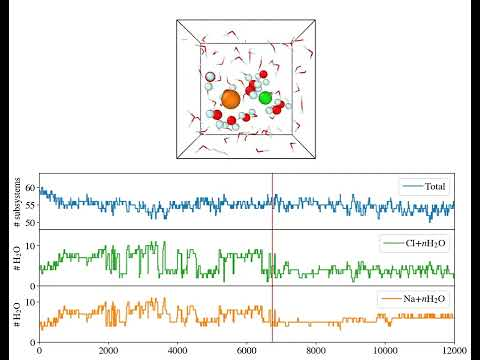

In [17]:
YouTubeVideo('-lmdPHzJfeU', width=800, height=500)

# Adaptive sDFT against experiments raw data for Pd<sup>2+</sup>
<center>
    <img src="figures/science/hydration/sq-pd.png" width=800 />
</center>


<center> <h3> sDFT compares better to raw experiments than EPSR </h3>

# Adaptive sDFT partial RDFs for Pd<sup>2+</sup>
<br>
<center>
    sDFT
    <img src="figures/science/hydration/pdpt-gofr.png" width=900 />
    EPSR "experiment"
    <img src="figures/science/hydration/Bowron_PdOw.png" width=400 />
</center>

<center>
    <b>sDFT prediction: no mesoshell.</b> Stay tuned... <a href="#/60/1">The End</a>
</center>

<center>
    <h1>Thank you!</h1>
    <ul>
        <li> Subsystem DFT</li>
        <li> Orbital-free DFT</li>
        <li> Combining methods for approaching "impossible" systems</li>
        <li> Choose your own adventure:
            <ul>
                <li>Using ML to replace electronic structure solvers</li>
                <li>Handling large metallic systems</li>
                <li>Deep dive on the hydration of group 10 aqua ions</li>
            </ul>
    </ul>
</center>